## 'wine_review.csv' 데이터를 통한 와인 리뷰 데이터 감성 분석 프로젝트
201921092 황준석

와인 리뷰 데이터셋을 사용하여 감성 분석(Sentiment Analysis)을 수행하는 프로젝트입니다. 감성 분석은 텍스트 데이터를 분석하여 그 감정을 분류하는 자연어 처리(NLP) 기술입니다. 이 프로젝트에서는 와인 리뷰를 긍정적 또는 부정적으로 분류하는 모델을 구축합니다. 이를 위해 데이터 전처리, 특징 추출, 모델 학습, 평가, 시각화의 단계를 거칩니다.

##### 1. 데이터 로드 및 구조 파악
먼저 'write_review.csv' 파일을 로드하고 데이터의 구조를 파악합니다.
각 컬럼의 개수와 데이터 타입을 확인하고, 처음 몇 개의 행을 출력하여 데이터의 전반적인 내용을 파악합니다.

In [126]:
import pandas as pd

# 데이터 로드
file_path = 'c:/clu/wine_review.csv' 
data = pd.read_csv(file_path)

# 데이터 구조 파악
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2890 non-null   object 
 1   asins                 870 non-null    object 
 2   brand                 2825 non-null   object 
 3   categories            2890 non-null   object 
 4   dateAdded             2890 non-null   object 
 5   dateUpdated           2890 non-null   object 
 6   descriptions          2738 non-null   object 
 7   dimension             1838 non-null   object 
 8   ean                   2166 non-null   object 
 9   flavors               151 non-null    object 
 10  keys                  2890 non-null   object 
 11  manufacturer          849 non-null    object 
 12  manufacturerNumber    2457 non-null   object 
 13  name                  2890 non-null   object 
 14  reviews.date          2552 non-null   object 
 15  reviews.dateAdded    

##### 데이터셋에는 총 2890개의 리뷰가 포함되어 있으며, 주요 속성으로는 'reviews.text'(리뷰 텍스트)와 'reviews.rating'(리뷰 평점)이 있습니다.

##### 데이터셋의 처음 몇 개의 행을 출력하여 데이터셋의 기본 정보가 다음과 같음을 알 수 있습니다.
1. id: 각 리뷰의 고유 식별자
2. asins: 제품의 ASIN (Amazon Standard Identification Number)
3. brand: 와인의 브랜드 이름
4. categories: 와인이 속한 카테고리 정보
5. dateAdded: 리뷰가 데이터베이스에 추가된 날짜
6. dateUpdated: 리뷰가 데이터베이스에 업데이트된 날짜
7. descriptions: 와인의 설명
8. dimension: 와인의 치수 정보
9. ean: 국제 상품 번호 (EAN: European Article Number)
10. flavors: 와인의 풍미를 설명하는 단어들
11. keys: 와인의 키워드
12. manufacturer: 제조사 정보
13. manufacturerNumber: 제조사의 제품 번호
14. name: 와인의 이름
15. reviews.date: 리뷰가 작성된 날짜
16. reviews.dateAdded: 리뷰가 추가된 날짜
17. reviews.dateSeen: 리뷰가 마지막으로 확인된 날짜
18. reviews.didPurchase: 구매 여부 (구매한 리뷰인지 여부)
19. reviews.doRecommend: 추천 여부 (리뷰 작성자가 제품을 추천하는지 여부)
...


##### 2. 필요한 컬럼 선택 및 결측값 처리
리뷰 텍스트('reviews.text)와 리뷰 평점('reviews.rating') 컬럼을 선택하고, 결측값을 제거합니다.

In [127]:
# 필요한 컬럼만 선택
data = data[['reviews.text', 'reviews.rating']]

# 결측값 제거
data = data.dropna(subset=['reviews.text', 'reviews.rating'])

print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
Index: 2444 entries, 0 to 2889
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    2444 non-null   object 
 1   reviews.rating  2444 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.3+ KB
None
                                        reviews.text  reviews.rating
0      This a fantastic white wine for any occasion!             5.0
1   Tart, not sweet...very refreshing and delicious!             5.0
2  I was given this wine so it was a delightful s...             5.0
3  This is a phenomenal wine and my new favorite ...             5.0
4  4 750ml bottles for the price of two With way ...             5.0


이 단계에서는 분석에 필요한 데이터만을 추출하고, 결측값이 있는 행을 제거하여 데이터의 완전성을 확보했습니다.

##### 3. 텍스트 전처리
텍스트 데이터를 분석하기 위해 NLTK를 사용하여 전처리 작업을 수행합니다.
텍스트 전처리에는 소문자로 변환, 구두점 제거, 토큰화, 불용어 제거, 표제어 추출 의 단계가 있습니다.

In [128]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 전처리 함수 정의
def preprocess_text(text):
    text = text.lower()  # 소문자로 변환
    text = text.translate(str.maketrans('', '', string.punctuation))  # 구두점 제거
    tokens = word_tokenize(text)  # 토큰화
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # 불용어 제거
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # 표제어 추출
    return ' '.join(tokens)

# 텍스트 전처리 적용
data['cleaned_text'] = data['reviews.text'].apply(preprocess_text)

print(data.head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\junsu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\junsu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\junsu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                        reviews.text  reviews.rating  \
0      This a fantastic white wine for any occasion!             5.0   
1   Tart, not sweet...very refreshing and delicious!             5.0   
2  I was given this wine so it was a delightful s...             5.0   
3  This is a phenomenal wine and my new favorite ...             5.0   
4  4 750ml bottles for the price of two With way ...             5.0   

                                        cleaned_text  
0                      fantastic white wine occasion  
1                tart sweetvery refreshing delicious  
2  given wine delightful surprise find flavorful ...  
3                   phenomenal wine new favorite red  
4  4 750ml bottle price two way le packaging yes ...  


##### 4. 감성 레이블 생성
리뷰 평점을 기준으로 감성 레이블을 생성합니다.
평점이 3 이상이면 긍정(1), 그렇지 않으면 부정(0)으로 분류합니다.

In [129]:
data['sentiment'] = data['reviews.rating'].apply(lambda x: 1 if x >= 3 else 0)
print(data.head())


                                        reviews.text  reviews.rating  \
0      This a fantastic white wine for any occasion!             5.0   
1   Tart, not sweet...very refreshing and delicious!             5.0   
2  I was given this wine so it was a delightful s...             5.0   
3  This is a phenomenal wine and my new favorite ...             5.0   
4  4 750ml bottles for the price of two With way ...             5.0   

                                        cleaned_text  sentiment  
0                      fantastic white wine occasion          1  
1                tart sweetvery refreshing delicious          1  
2  given wine delightful surprise find flavorful ...          1  
3                   phenomenal wine new favorite red          1  
4  4 750ml bottle price two way le packaging yes ...          1  


##### 5. 텍스트 데이터를 TF-IDF 벡터화
TF-IDF(Vectorizer)를 사용하여 텍스트 데이터를 벡터화합니다.
이는 각 단어의 중요도를 계산하여 텍스트 데이터를 숫자로 변환하는 과정입니다.

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['cleaned_text'])
y = data['sentiment']


##### 6. 데이터셋 분할
데이터셋을 학습 세트와 테스트 세트로 분할합니다.학습 세트는 모델을 학습하는 데 사용하고, 테스트 세트는 모델의 성능을 평가하는 데 사용합니다.

In [131]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##### 7. 모델 학습
로지스틱 회귀(Logistic Regression) 모델을 사용하여 학습 세트를 기반으로 모델을 학습합니다.

In [132]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

##### 8. 예측
테스트 세트를 사용하여 모델이 감성을 예측하도록 합니다.

In [133]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


##### 9. 모델 평가
모델의 성능을 평가하기 위해 여러 지표를 계산합니다.
1. 정확도 (Accuracy)
2. 정밀도 (Precision)
3. 재현율 (Recall)
4. F1 스코어 (F1 Score)
5. ROC AUC (Receiver Operating Characteristic Area Under Curve)

In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

#성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

evaluation_results = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

print(evaluation_results)


{'Accuracy': 0.9611451942740287, 'Precision': 0.9611451942740287, 'Recall': 1.0, 'F1 Score': 0.9801876955161627, 'ROC AUC': 0.9088465845464726}


##### 주요 결과
정확도 (Accuracy), 정밀도 (Precision): 96.1%로, 모델이 대부분의 리뷰를 올바르게 분류, 긍정 리뷰를 정확하게 예측했습니다.
재현율 (Recall): 100%로, 모든 긍정 리뷰를 정확하게 예측했습니다.
F1 스코어 (F1 Score): 98%로, 정밀도와 재현율 모두에서 높은 성능을 보였습니다.
ROC AUC (Positive Reviews): 91.6%로, 긍정 리뷰에 대한 예측 성능이 매우 우수했습니다.

10. 혼동 행렬 및 ROC 곡선 시각화
혼동 행렬과 ROC 곡선을 시각화하여 모델의 성능을 보다 직관적으로 이해합니다.

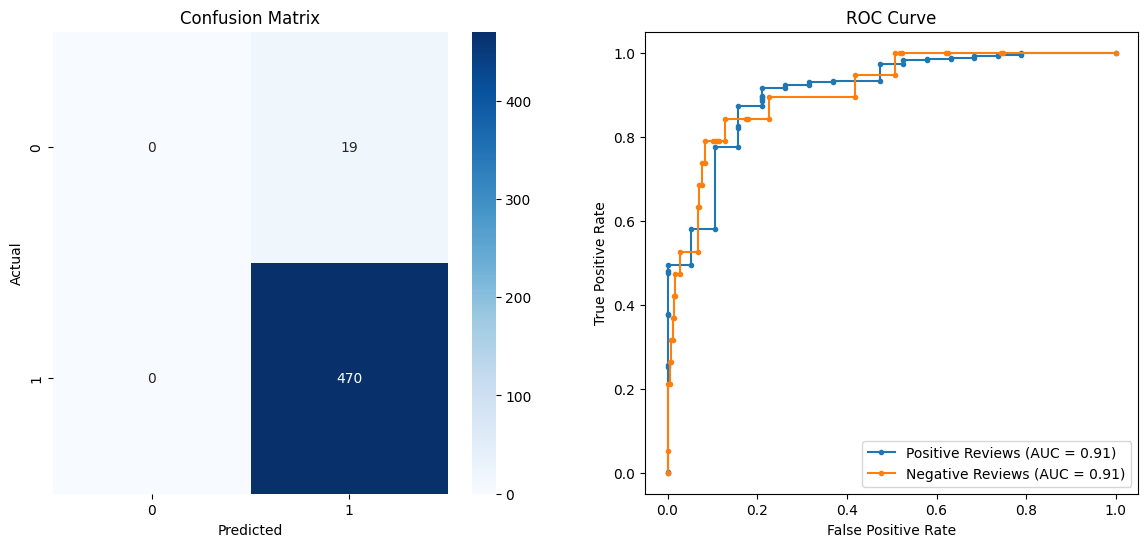

Negative ROC AUC: 0.9088465845464725


In [135]:
# 혼동 행렬 및 ROC 곡선 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 부정 리뷰의 라벨을 반전시켜 1(부정), 0(긍정)으로 만들기
y_test_negative = 1 - y_test
y_prob_negative = 1 - y_prob

# 부정 리뷰의 ROC 곡선 계산
fpr_neg, tpr_neg, _ = roc_curve(y_test_negative, y_prob_negative)
roc_auc_neg = roc_auc_score(y_test_negative, y_prob_negative)

# 결과 시각화
plt.figure(figsize=(14, 6))

# 혼동 행렬 시각화
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC 곡선 시각화
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.', label='Positive Reviews (AUC = {:.2f})'.format(roc_auc))
plt.plot(fpr_neg, tpr_neg, marker='.', label='Negative Reviews (AUC = {:.2f})'.format(roc_auc_neg))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

print("Negative ROC AUC:", roc_auc_neg)


##### 혼동 행렬 및 ROC 곡선 해석
혼동 행렬 (Confusion Matrix)

True Positives (TP): 긍정 리뷰인 경우를 긍정으로 예측한 샘플 수는 470개이고,
False Positives (FP): 부정 리뷰인 경우를 긍정으로 예측한 샘플 수는 19개입니다.
True Negatives (TN): 이 프로젝트에서는 없습니다. 이는 부정 리뷰를 부정으로 예측한 경우가 없음을 의미합니다. 또한 False Negatives (FN): 실제로 긍정 리뷰인 경우를 부정으로 예측한 샘플 수는 0개입니다.
모델은 긍정 리뷰는 매우 잘 예측하지만, 부정 리뷰는 잘 예측하지 못했습니다. 이는 부정 리뷰에 대한 예측 성능이 낮다는 것을 보여주며 모델을 개선할 필요성이 보입니다.

ROC 곡선 (ROC Curve)

Positive Reviews (AUC = 0.91): ROC 곡선에서 AUC 값이 0.91로, 긍정 리뷰를 예측하는 데 있어 모델의 성능이 매우 우수합니다.
Negative Reviews (AUC = 0.91): ROC 곡선에서 AUC 값이 0.91로, 부정 리뷰를 예측하는 데 있어 모델의 성능이 긍정 리뷰와 비슷하게 나타났습니다.
하지만 혼동 행렬에서 부정 리뷰를 잘 예측하지 못한 결과를 고려했을 때, 부정 리뷰에 대한 예측 성능이 좋지 않았습니다. 이는 클래스 불균형 문제나 모델의 편향된 학습 때문일 수 있으며, 클래스 불균형 해결 개선이 필요하다고 생각됩니다.

##### 결론
부정 리뷰에 대한 ROC AUC 값이 0.91인 것은 모델이 부정 리뷰를 예측하는 데 있어 좋은 성능을 보였음을 의미합니다. 그러나 혼동 행렬에서 모델이 부정 리뷰를 잘 예측하지 못한 점을 고려했을 떄, 예측 성능을 향상시키기 위해 클래스 불균형 문제를 해결하고, 모델을 개선해야할 필요성이 보입니다.